# Parameter space exploration analysis

In [90]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from config import EXPLORATION_SPACE
%matplotlib inline

In [43]:
# loading results of parameter space exploration
with open('results-space.json', 'r') as fp:
    data = json.load(fp)

In [44]:
# check keys of stored values
data.keys()

dict_keys(['best', 'trials', 'results', 'best_trial', 'stepPoints', 'stepDistr'])

In [45]:
# nr of evaluations
print('Nr of evaluations performed:', len(data['trials']))

Nr of evaluations performed: 2500


In [46]:
# configuration used for hyperparameter space exploration
config = EXPLORATION_SPACE

In [67]:
# parsing all results
allResults = [res['loss'] for res in data['results']]

# extract results
results = {}
for trial in data['trials']:
    res = trial['misc']['vals']
    loss = trial['result']['loss']
    for k in config.keys():
        results.setdefault(k, {})
        results[k].setdefault(res[k][0], [])
        results[k][res[k][0]].append(loss)
results.keys()

dict_keys(['populationSize', 'crossoverPB', 'mutationPB', 'nrGenerations', 'notImprovingLimit'])

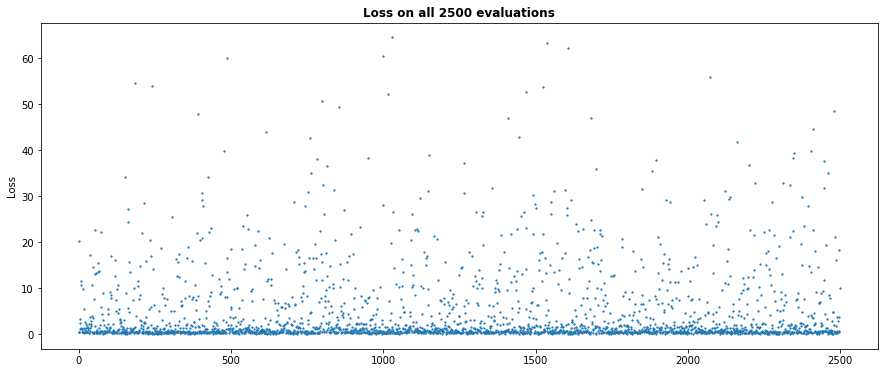

In [112]:
# plot loss value of all evaluations
fig, ax = plt.subplots(figsize=(15, 6))
_ = ax.scatter(np.arange(len(allResults)), allResults, s=1.5)
_ = ax.set_title('Loss on all {} evaluations'.format(len(data['trials'])), fontweight='bold')
_ = ax.set_ylabel('Loss')
fig.savefig('001-overall-loss.pdf', bbox_inches='tight')

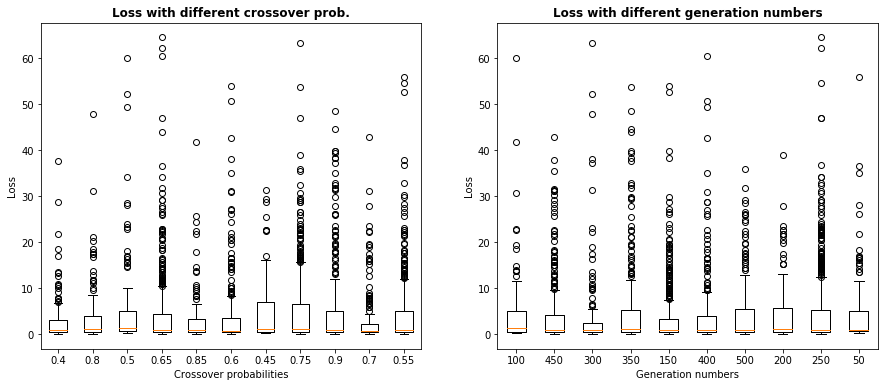

In [113]:
# check loss using different window sizes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))
# batch size
orderId = [config['crossoverPB'][i] for i in results['crossoverPB'].keys()]
_ = ax1.boxplot(results['crossoverPB'].values())
_ = ax1.set_xticklabels(np.round(orderId, 2))
_ = ax1.set_ylabel('Loss')
_ = ax1.set_xlabel('Crossover probabilities')
_ = ax1.set_title('Loss with different crossover prob.', fontweight='bold')
# loss with two vs one layers
orderId = [config['nrGenerations'][i] for i in results['nrGenerations'].keys()]
_ = ax2.boxplot(results['nrGenerations'].values())
_ = ax2.set_xticklabels(orderId)
_ = ax2.set_ylabel('Loss')
_ = ax2.set_xlabel('Generation numbers')
_ = ax2.set_title('Loss with different generation numbers', fontweight='bold')
#fig.savefig('002-loss-crossgen.pdf', bbox_inches='tight')

# Best trial
Parameter value for the best overall trial

In [16]:
print('Best trial is achieved using:')
for k in data['best'].keys():
    print('{}: {}'.format(k, config[k][data['best'][k]]))
print()
print('Best trial raw:')
data['best_trial']

Best trial is achieved using:
crossoverPB: 0.75
mutationPB: 0.5000000000000001
notImprovingLimit: 10
nrGenerations: 450
populationSize: 350

Best trial raw:


{'book_time': '2019-01-31 10:35:54.781000',
 'exp_key': None,
 'misc': {'cmd': ['domain_attachment', 'FMinIter_Domain'],
  'idxs': {'crossoverPB': [1274],
   'mutationPB': [1274],
   'notImprovingLimit': [1274],
   'nrGenerations': [1274],
   'populationSize': [1274]},
  'tid': 1274,
  'vals': {'crossoverPB': [7],
   'mutationPB': [8],
   'notImprovingLimit': [1],
   'nrGenerations': [8],
   'populationSize': [5]},
  'workdir': None},
 'owner': None,
 'refresh_time': '2019-01-31 10:36:07.428000',
 'result': {'loss': 0.04133238612801962, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 1274,
 'version': 0}

# Check statistics on 15 best trials
Check parameter values in the first 15 best results to check if there is some consistency or pattern

In [78]:
# create dataframe with parameter values of the top 15 trials
sortedResults = sorted(allResults)
order = np.argsort(allResults)
topResults = [res['misc']['vals'] for res in data['trials'] if res['result']['loss'] in sortedResults[:15]]
# convert lists to values
for e in topResults:
    for k,v in e.items():
        if type(v) == type(list()):
            e[k] = v[0]
df = pd.DataFrame(topResults)
df['points'] = [data['stepPoints'][i] for i in order][:15]
df.head()

,crossoverPB,mutationPB,notImprovingLimit,nrGenerations,populationSize,points
0,4,6,5,9,4,30
1,5,3,4,7,4,60
2,10,5,4,7,0,30
3,7,8,1,8,5,70
4,3,4,4,8,6,10


In [79]:
# isolate each parameter 
def convertValue(row):
    row['Real value'] = config[c][row.name]
    return row
for c in df.columns:
    print('## Top 15 values for parameter: {}'.format(c))
    dfs = df[c].value_counts().to_frame()
    dfs.columns = ['Counts']
    dfs.index.name = 'Raw value'
    if c != 'points':
        dfs = dfs.apply(convertValue, axis=1)
    print(dfs)
    print()

## Top 15 values for parameter: crossoverPB
           Counts  Real value
Raw value                    
10            5.0        0.90
3             4.0        0.55
7             3.0        0.75
5             2.0        0.65
4             1.0        0.60

## Top 15 values for parameter: mutationPB
           Counts  Real value
Raw value                    
4             7.0        0.30
3             4.0        0.25
5             2.0        0.35
8             1.0        0.50
6             1.0        0.40

## Top 15 values for parameter: notImprovingLimit
           Counts  Real value
Raw value                    
4              11          25
5               2          30
1               2          10

## Top 15 values for parameter: nrGenerations
           Counts  Real value
Raw value                    
6               4         350
4               4         250
8               2         450
7               2         400
2               2         150
9               1         500

## 

Lets isolate each point distribution to see the mean value of each parameter. The goal would be to find a single value for each parameter which works well for all point distributions. This assumption might be unreasonable and can be investidated through appropriate plots.

In [80]:
# function to convert raw values from hyperopt to real values from config file
def convert(row):
    for col in [col for col in row.index if col not in ['point', 'fitness']]:
        row[col] = config[col][int(row[col])]
    return row

# number of best results to consider to compute the statistics
topPoints = 15
uniquePoints = sorted(set(data['stepPoints']))
dfData = []
for point in uniquePoints:
    # find all points matching
    pointIds = [i for i, el in enumerate(data['stepPoints']) if el==point]
    pointResults = [allResults[i] for i in pointIds]
    pointResultsOrdered = sorted(pointResults)
    
    order = np.argsort(pointResults)
    pointTrials = [data['trials'][i] for i in pointIds]
    # for each point distribution, extract the topPoints in terms of loss
    pointTrials = [pointTrials[i] for i in order][:topPoints]
    topResults = [res['misc']['vals'] for res in pointTrials]
    
    # convert lists to values
    for i,e in enumerate(topResults):
        singleResult = {}
        for k,v in e.items():
            if type(v) == type(list()):
                singleResult[k] = v[0]
            else:
                singleResult[k] = v
        singleResult['point']=point
        singleResult['fitness']=pointResultsOrdered[i]
        dfData.append(singleResult)
df = pd.DataFrame(dfData, dtype='float')
df = df.apply(convert, axis=1)
df.head()

,crossoverPB,fitness,mutationPB,notImprovingLimit,nrGenerations,point,populationSize
0,0.40,1.059105,0.15,10.0,50.0,10.0,100.0
1,0.45,2.150948,0.25,5.0,400.0,10.0,100.0
2,0.75,2.171418,0.30,10.0,150.0,10.0,100.0
3,0.75,2.727506,0.10,10.0,400.0,10.0,100.0
4,0.55,2.924174,0.25,10.0,500.0,10.0,150.0


In [81]:
# group above dataframe by point in order to show specific statistics
dfGrouped = df.groupby(['point']).agg(['mean','std'])
dfGrouped

crossoverPB             fitness           mutationPB            \
             mean       std      mean       std       mean       std   
point                                                                  
10.0     0.673333  0.162422  3.151188  0.904503   0.263333  0.136887   
20.0     0.656667  0.130749  1.403012  0.432514   0.360000  0.179483   
30.0     0.583333  0.141000  0.659314  0.128867   0.356667  0.132107   
40.0     0.626667  0.130749  0.511137  0.040908   0.323333  0.172033   
50.0     0.620000  0.108233  0.314846  0.037552   0.353333  0.131566   
60.0     0.703333  0.106010  0.065805  0.010871   0.336667  0.107681   
70.0     0.696667  0.140746  0.077638  0.020028   0.333333  0.127709   
80.0     0.573333  0.119323  0.194713  0.014487   0.343333  0.106682   

      notImprovingLimit           nrGenerations             populationSize  \
                   mean       std          mean         std           mean   
point                                                                        
10.0          11.333333  6.935073    316.666667  156.600797     143.333333   
20.0           9.333333  5.627314    256.666667  164.606312     183.333333   
30.0          16.000000  8.493695    320.000000  122.182533     116.666667   
40.0          13.000000  7.973169    286.666667  166.332999     156.666667   
50.0          16.333333  8.121107    343.333333  137.407978     243.333333   
60.0          19.000000  7.606388    296.666667  110.948293     350.000000   
70.0          24.333333  5.627314    363.333333   87.559504     360.000000   
80.0          18.666667  9.347778    286.666667  121.694387     270.000000   

                   
              std  
point              
10.0    70.373155  
20.0   109.653133  
30.0    40.824829  
40.0    70.373155  
50.0   122.279929  
60.0    80.178373  
70.0    63.245553  
80.0   122.182533

In [82]:
# Helper function to return plot row and column
def currentRowCol(c,cols,rows):
    if rows == 1 or cols == 1:
        return c,0
    row = math.floor(c/cols)
    col = c-row*cols
    return row,col

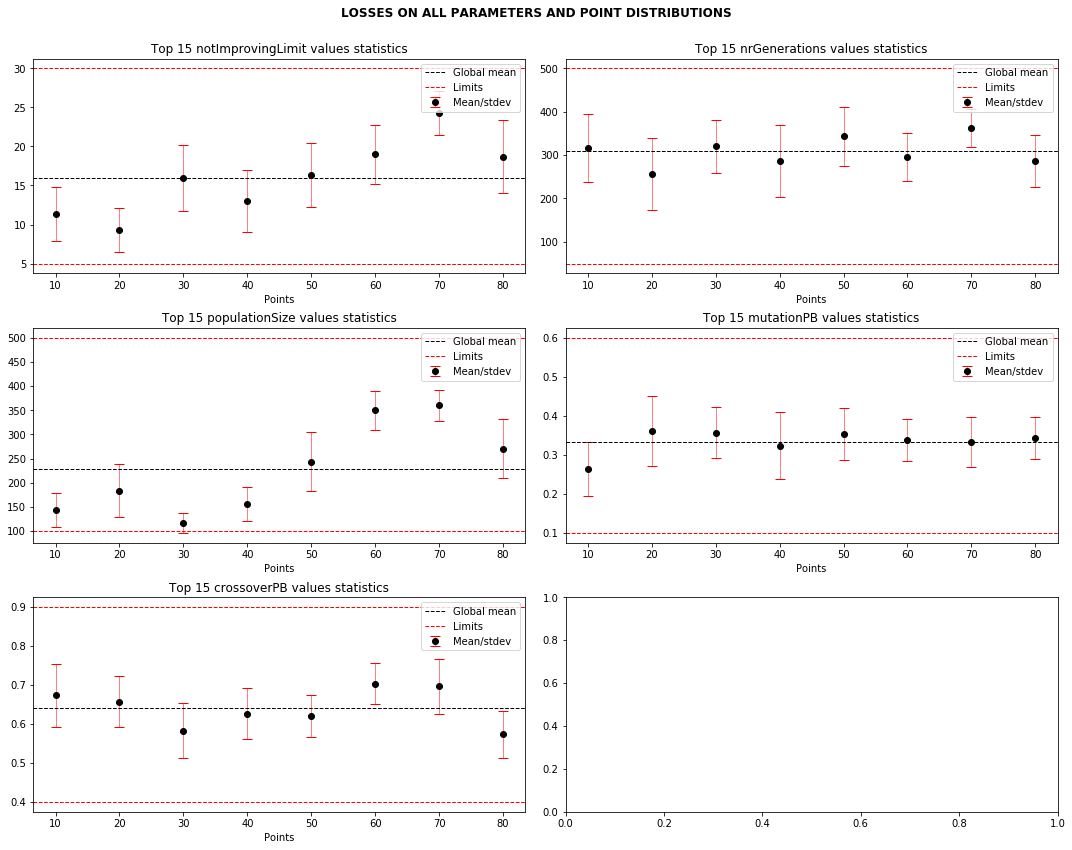

In [114]:
cols = 2
rows = 3
fig, ax = plt.subplots(rows,cols,figsize=(15,12))
fig.suptitle('LOSSES ON ALL PARAMETERS AND POINT DISTRIBUTIONS', fontweight='bold')
for i,groupName in enumerate(set(dfGrouped.columns.get_level_values(0))):
    if groupName == 'fitness':
        continue
    r,c = currentRowCol(i,cols,rows)
    group = dfGrouped[groupName]
    x = group.index
    y = group['mean']
    e = group['std']/2
    ax[r,c].errorbar(x,y,e, linestyle='None', marker='o', color='k', capsize=5, ecolor='r', elinewidth=0.5, label='Mean/stdev')
    ax[r,c].axhline(y=np.mean(y), linewidth=1, color='k', linestyle='--', label='Global mean')
    ax[r,c].axhline(y=config[groupName][0], linewidth=1, color='r', linestyle='--', label='Limits')
    ax[r,c].axhline(y=config[groupName][-1], linewidth=1, color='r', linestyle='--')
    ax[r,c].legend(loc='upper right')
    ax[r,c].set_title('Top 15 {} values statistics'.format(groupName))
    ax[r,c].set_xlabel('Points')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig.savefig('003-parameters-points-loss.pdf', bbox_inches='tight')

As it was expected, the optimal values for each parameter varies significantly over different point distributions.

In [108]:
# The mean values shown above in the black dotted line, which will be used
# as optimal parameters for the final genetic algorithm
np.round(dfGrouped.mean(),2)

crossoverPB        mean      0.64
                   std       0.13
fitness            mean      0.80
                   std       0.20
mutationPB         mean      0.33
                   std       0.14
notImprovingLimit  mean     16.00
                   std       7.47
nrGenerations      mean    308.75
                   std     133.42
populationSize     mean    227.92
                   std      84.89
dtype: float64